# Домашняя работа по методам оптимизации

**Студент:** Феоктистов Владислав Сергеевич

**Группа:** НПМбд-01-19б

## Подготовка рабочего пространства

Для начала загрузим все необходимые библиотеки.

In [87]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
import scipy

Напишем функции для численного нахождения частной производной, градиента и матрицы Гесса для заданной функции в указанной точке.

Для начала выведем все необходимые формулы. Пусть $x \in \mathbb{R}^n$ и $f \in C^1$. Тогда частная производная функции $f(x_1, ..., x_i, ..., x_n)$ по $x_i$ находится по формуле:

$\frac{\partial f}{\partial x_i} = \lim \limits_{\Delta \to 0} \frac{f(x_1, ..., x_i + \Delta, ..., x_n) - f(x_1, ..., x_i, ..., x_n)}{\Delta} $

Градиент находится по следующей формуле:

$\vec{grad(f)} = \nabla f = \begin{pmatrix} \frac{\partial f}{\partial x_1} & ... & \frac{\partial f}{\partial x_i} & ... & \frac{\partial f}{\partial x_n} \end{pmatrix}^T = \begin{pmatrix} \lim \limits_{\Delta \to 0} \frac{f(x_1 + \Delta, ..., x_i, ..., x_n) - f(x_1, ..., x_i, ..., x_n)}{\Delta} & ... & \lim \limits_{\Delta \to 0} \frac{f(x_1, ..., x_i, ..., x_n + \Delta) - f(x_1, ..., x_i, ..., x_n)}{\Delta} \end{pmatrix}^T$

Матрица Гесса выглядит следующим образом:

$H_f = \nabla^2 f = \begin{pmatrix} 
                        \frac{\partial^2 f}{\partial x_1^2} & ... & \frac{\partial^2f}{\partial x_1 \partial x_i} & ... & \frac{\partial^2f}{\partial x_1 \partial x_n}\\
                        ... & ... & ... & ... & ... \\
                        \frac{\partial^2f}{\partial x_i \partial x_1} & ... & \frac{\partial^2f}{\partial x_i^2} & ... & \frac{\partial^2f}{\partial x_i \partial x_n}\\
                        ... & ... & ... & ... & ... \\
                        \frac{\partial^2f}{\partial x_n \partial x_1} & ... & \frac{\partial^2f}{\partial x_n \partial x_i} & ... & \frac{\partial^2f}{\partial x_n^2}\\
                     \end{pmatrix}$
                     
Для неё необходимо, чтобы $f \in C^2$                     
                     
Как можно заметить, для того, чтобы найти матрицу Гесса, нам нужно вывести формулу нахождения частной производной второго порядка по определению, т.е. через предел (поскольку численно производные можно находить только через формулы пределов, подставляя под дельту маленькое число). Итак, выведим формулу частной производной второго порядка по определению:

$\frac{\partial^2f}{\partial x_j \partial x_i} = \lim \limits_{\Delta \to 0} \frac{\frac{\partial f}{\partial x_j}f(x_1, ..., x_i + \Delta, ..., x_j, ..., x_n) - \frac{\partial f}{\partial x_j}f(x_1, ..., x_i, ..., x_j, ..., x_n)}{\Delta} =$

$= \lim \limits_{\Delta \to 0} \frac{\lim \limits_{\Delta \to 0} \frac{f(x_1, ..., x_i + \Delta, ..., x_j + \Delta, ..., x_n) - f(x_1, ..., x_i + \Delta, ..., x_j, ..., x_n)}{\Delta} - \lim \limits_{\Delta \to 0} \frac{f(x_1, ..., x_i, ..., x_j + \Delta, ..., x_n) - f(x_1, ..., x_i, ..., x_j, ..., x_n)}{\Delta}}{\Delta} =$

$ = \lim \limits_{\Delta \to 0} \frac{f(x_1, ..., x_i + \Delta, ..., x_j + \Delta, ..., x_n) - f(x_1, ..., x_i + \Delta, ..., x_j, ..., x_n) - f(x_1, ..., x_i, ..., x_j + \Delta, ..., x_n) + f(x_1, ..., x_i, ..., x_j, ..., x_n)}{\Delta^2}$

Теперь мы можем, используя выведенные формулы написать функции численного нахождения частной производной, градиента и матрицы Гесса для заданной функции в указанной точке.

In [2]:
def diff(f, x, i=0, eps=0.01):
    x_right = np.copy(x)
    x_right[i] += eps
    return (f(x_right) - f(x)) / eps

def grad(f, x, eps=0.01):
    n = len(x)
    E = np.eye(n)
    return np.array([(f(x + eps * E[i]) - f(x)) / eps for i in range(n)])

def hess(f, x, eps=0.01):
    n = len(x)
    E = np.eye(n)
    res = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            res[i, j] = (f(x + eps * E[i] + eps * E[j]) - f(x + eps * E[i]) - f(x + eps * E[j]) + f(x)) / eps**2
            res[j, i] = res[i, j]
    return res

## Задача 1. Одномерная оптимизация. Метод ломаных.

**Задача 17.68:** Методом ломаных найти минимум $f^{*}$ функции $f(x) = -\sqrt{20x - x^2} + 0.01sin(x)$ на отрезке $[9;11]$ с точность $\epsilon = 0.05$.

Идея метода ломаных заключается в аппроксимации целевой функции f кусочно-линейной функцией, звенья которой имеют угловые коэффициенты ±L. В качестве минимального значения функции f принимается минимальное значение функции, графиком которой является эта ломанная.

### Теория

**Алгоритм:** описан на 26 странице в pdf файле https://alexey-abakumkin.github.io/lectures-sem-2/CM/CM2.pdf
0. Найдем точку $(x_0, y_0)$ - минимум функции $y = f(x_0) - L|x - x_0|$ 

3.1443863395279466
0.8673061045373819
0.42494698982562307
0.21430758581616377
0.1056452077304478
0.05252261596094054
0.026220332421139348
0.013116427023675357
0.0065528579985044706
0.003275423127381931
0.0016376250445137627
0.0008188211278138332
10.079532948465145 -10.005773369689255
Время работы метода 0.28916510000271956 сек


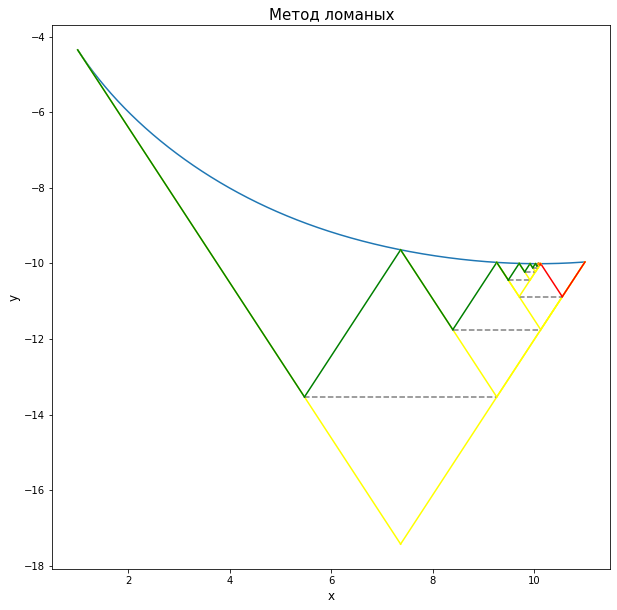

In [112]:
def f(x):
    return -np.sqrt(20*x - x**2) + 0.01 * np.sin(x)

def diff(f, x, eps = 0.01):
    return (f(x + eps) - f(x)) / eps

def polyline_method(f, segment, L=0, n=1000, prec=1e-6):
    a, b = segment
    x = np.linspace(a, b, n)
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xlabel('x', fontsize = 12)
    ax.set_ylabel('y', fontsize = 12)
    ax.set_title('Метод ломаных', fontsize = 15)
    ax.plot(x, f(x), linestyle='-')
    if L == 0:
        L = np.max(np.abs(diff(f, x)))
#         L = np.max(x)
    
    x_k = (f(a) - f(b) + L * (a + b)) / (2 * L)
    y_k = (f(a) - f(b) + L * (a - b)) / 2
    
    p_k = f(a) - L * (x_k - a)
    point = np.array([x_k, y_k])
    point_prev = point + 2 * prec

    k = 0
    while prec <= np.linalg.norm(point - point_prev):
        delta_k_next = (f(x_k) - p_k) / (2 * L)
        x_k_left = x_k - delta_k_next
        x_k_right = x_k + delta_k_next
        x_k_prev = x_k
        p_k_prev = p_k
        p_k = (f(x_k) + p_k) / 2
        
        x1 = np.array([a, x_k])
        x2 = np.array([x_k, b])
        
        ax.plot(x1, f(a) - L * (x1 - a), linestyle='-', c='yellow')
        ax.plot(x2, f(b) + L * (x2 - b), linestyle='-', c='yellow')
        ax.plot(np.array([x_k_left, x_k_right]), np.array([p_k]*2), linestyle='--', c='gray')
        
        if f(x_k_left) < f(x_k_right):
            # Выбираем левую сторону движения, а рисуем правую красным
            x3 = np.array([x_k, x_k_right])
            x4 = np.array([x_k_right, b])
            ax.plot(x3, f(x_k) - L * (x3 - x_k), linestyle='-', c='red')
            ax.plot(x4, f(b) + L * (x4 - b), linestyle='-', c='red')
            point_prev = np.copy(point)
            point = np.array([x_k_left, f(x_k_left)])
            b = x_k
            x_k = x_k_left
        else:
            # Выбираем правую сторону движения, а рисуем левую зеленым
            x3 = np.array([a, x_k_left])
            x4 = np.array([x_k_left, x_k])
            ax.plot(x3, f(a) - L * (x3 - a), linestyle='-', c='green')
            ax.plot(x4, f(x_k) + L * (x4 - x_k), linestyle='-', c='green')
            point_prev = np.copy(point)
            point = np.array([x_k_right, f(x_k_right)])
            a = x_k
            x_k = x_k_right
        print(np.linalg.norm(point - point_prev))
        k += 1
    
    x1 = np.array([a, x_k])
    x2 = np.array([x_k, b])
        
    ax.plot(x1, f(a) - L * (x1 - a), linestyle='-', c='orange')
    ax.plot(x2, f(b) + L * (x2 - b), linestyle='-', c='orange')
    
    return x_k, k

if __name__ == '__main__':
    start = time.perf_counter()
    res = polyline_method(f, segment = (1, 11), prec = 0.001)
    print(res[0], f(res[0]))
    print('Время работы метода', time.perf_counter() - start, 'сек')

### Теория

Пусть для функции $f, x \in [a, b] \exists L \gt 0$: $\|f(x) - f(x')\| \leq L{\lVert x - x' \rVert}$. Если $f \in C^1$, то $L = max_{x \in [a, b]} | f'(x) |$.

Фиксируем $N \gt 0, h = \frac{b - a}{N}, x_i = a + ih$. Получаем множество точек $\{(x_i, f(x_i))\}, i=\overline{1,N}$. Для них построим прямые $y = f(x_i) \pm L(x - x_i)$ и найдем точки их пересечений:

$y = \begin{cases}
    f(x_i) - L(x - x_i)\\
    f(x_{i+1}) + L(x - x_{i+1})
\end{cases} => (\overline{x_i}, \overline{y_i})$ - вершины ломанной $x_i < \overline{x_i} < x_{i+1}$

$min_{x \in верш. лом.} f(x) = f^0 \geq min_{x \in [a, b]} f(x) = f^* \geq min_i \overline{y_i}$

$| A - B | \leq kLh$

2 9.987984193602196 -10.533892741162726
Время работы метода 0.040909800001827534 сек


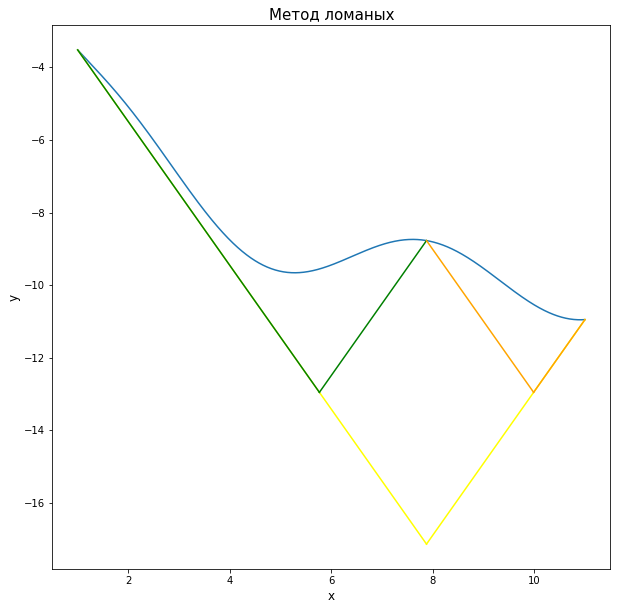

In [110]:
def f(x):
    return -np.sqrt(20*x - x**2) + np.sin(x)

def diff(f, x0, h = 0.01):
    return (f(x0 + h) - f(x0)) / h

def polyline_method(f, segment, L = 0, n = 1000, prec = 0.0001):
    a, b = segment
    x = np.linspace(a, b, n)
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xlabel('x', fontsize = 12)
    ax.set_ylabel('y', fontsize = 12)
    ax.set_title('Метод ломаных', fontsize = 15)
    ax.plot(x, f(x), linestyle='-')
    if L == 0:
        L = np.max(np.abs(diff(f, x)))
#         L = np.max(x)
    
    x_k = (f(a) - f(b) + L * (a + b)) / (2 * L)
    y_k = (f(a) - f(b) + L * (a - b)) / 2
    
    points = [np.array([x_k, y_k])]
    
    iters = 0
    while True:
        x1 = np.array([a, x_k])
        x2 = np.array([x_k, b])
        
        ax.plot(x1, f(a) - L * (x1 - a), linestyle='-', c='yellow')
        ax.plot(x2, f(b) + L * (x2 - b), linestyle='-', c='yellow')
        
        x_k_left = (f(a) - f(x_k) + L * (a + x_k)) / (2 * L)
        y_k_left = (f(a) - f(x_k) + L * (a - x_k)) / 2  
        
        x_k_right = (f(x_k) - f(b) + L * (x_k + b)) / (2 * L)
        y_k_right = (f(x_k) - f(b) + L * (x_k - b)) / 2
        
        if y_k_left > y_k_right:
            # Выбираем левую сторону движения, а рисуем правую красным
            x3 = np.array([x_k, x_k_right])
            x4 = np.array([x_k_right, b])
            ax.plot(x3, f(x_k) - L * (x3 - x_k), linestyle='-', c='red')
            ax.plot(x4, f(b) + L * (x4 - b), linestyle='-', c='red')
            b = x_k
            x_k = x_k_left
            points.append(np.array([x_k_left, y_k_left]))
        else:
            x3 = np.array([a, x_k_left])
            x4 = np.array([x_k_left, x_k])
            ax.plot(x3, f(a) - L * (x3 - a), linestyle='-', c='green')
            ax.plot(x4, f(x_k) + L * (x4 - x_k), linestyle='-', c='green')
            a = x_k
            x_k = x_k_right
            points.append(np.array([x_k_right, y_k_right]))
        
        if prec <= np.linalg.norm(points[-1] - points[-2]):
            break
           
    x1 = np.array([a, x_k])
    x2 = np.array([x_k, b])
        
    ax.plot(x1, f(a) - L * (x1 - a), linestyle='-', c='orange')
    ax.plot(x2, f(b) + L * (x2 - b), linestyle='-', c='orange')
    
    return points

if __name__ == '__main__':
    start = time.perf_counter()
    res = polyline_method(f, segment = (1, 11), prec = 0.05)[-1]
    print(x, f(res[0]))
    print('Время работы метода', time.perf_counter() - start, 'сек')

## Задача 2. Многомерная оптимизация. Метод Ньютона.

**Задача 17.149:** Методом Ньютона найти минимум $f^{*}$ функции $f(x) = x_1^2 + 2x_2^2 + e^{x_1^2 + x_2^2} -x_1 + 2x_2$. 

### Теория

Центральной проблемой оптимизации является минимизация функций. Давайте сначала рассмотрим случай одномерных функций, т.е. Функций одной действительной переменной. Позже мы рассмотрим более общий и более практичный многомерный случай.

Учитывая дважды дифференцируемую функцию ${\displaystyle f:\mathbb {R} \to \mathbb {R} }$, мы стремимся решить задачу оптимизации

$\min \limits_{x \in \mathbb{R}}f(x)$

Метод Ньютона пытается решить эту проблему путем построения последовательности $x_k$ из начального предположения (начальной точки) $x_0 \in \mathbb{R}$, которая сходится к минимизатору $x_*f$, используя последовательность приближений Тейлора второго порядка $f$ вокруг итераций. 

Разложение Тейлора второго порядка $f$ вокруг $x_{k}$ равно

$f(x_k+t)\approx f(x_k)+f'(x_k)t+{\frac {1}{2}}f''(x_k)t^2$.


Следующая итерация $x_{k+1}$ определяется таким образом, чтобы минимизировать это квадратичное приближение в $t$, и настройка $x_{k+1}=x_{k}+t$. Если вторая производная положительна, квадратичное приближение является выпуклой функцией $t$, и ее минимум можно найти, установив производную равной нулю. Поскольку

$0=\frac {d}{dt} \left( f(x_k) + f'(x_k)t + \frac {1}{2}f''(x_k)t^{2} \right) = f'(x_k) + f''(x_k)t$, 

минимум достигается для

$t = -\frac {f'(x_k)}{f''(x_k)}$.

Объединяя все вместе, метод Ньютона выполняет итерацию

$x_{k+1} = x_k + t = x_k - \frac {f'(x_k)}{f''(x_k)}$.

Приведенную выше итерационную схему можно обобщить на $n \gt 1$ размерности, заменив производную на градиент (разные авторы используют разные обозначения для градиента, в том числе $f'(x) = \nabla f(x) = g_f(x) \in \mathbb{R}^n$), а обратную вторую производную на обратную матрицу Мешковины (разные авторы используют разные обозначения для мешковины, в том числе $f''(x) = \nabla^2 f(x) = H_f(x) \in \mathbb{R}^{n \times n}$). Таким образом, получается итерационная схема

$x_{k+1}=x_k - \frac{\nabla f(x)}{\nabla^2 f(x)}$, $\qquad k \geq 0$.

Часто метод Ньютона модифицируется для включения небольшого размера шага $0 \lt \gamma \leq 1$ вместо $\gamma = 1$:

$x_{k+1} = x_k - \gamma H_f^{-1}(x_k) \nabla f(x_k)$.

Это часто делается для того, чтобы гарантировать выполнение условий Вульфа или гораздо более простого и эффективного условия Армихо на каждом шаге метода. Для размеров шага, отличных от 1, этот метод часто называют расслабленным или затухающим методом Ньютона.

Геометрическая интерпретация метода Ньютона заключается в том, что на каждой итерации он сводится к подгонке параболы к графику $f(x)$ с пробным значением $x_k$, имеющим тот же наклон и кривизну, что и график в этой точке, а затем переходит к максимуму или минимуму этой параболы (в более высоких измерениях этотакже может быть седловой точкой). Обратите внимание, что если $f$ это квадратичная функция, то точный экстремум находится за один шаг.

### Программа

Напишем функцию нахождения локального минимума методом Ньютона для заданной функции, начиная с указанной точки $x$.

In [93]:
def newton_method(f, x, grad=grad, hess=hess, eps=0.01, alpha=0.1, prec=0.001):
    x = x.astype(float)
    X = [x]
    # Аналог цикла do while
    while True: 
        direct = grad(f, X[-1], eps).reshape((1, len(X[-1])))
        direct = direct @ np.linalg.inv(hess(f, X[-1], eps))
        direct = direct.flatten()
        X.append(X[-1] - alpha * direct)
        if np.linalg.norm(X[-1] - X[-2]) < prec:
            break
    return np.array(X)

Напишем функцию для построения 2D-графика уровня и 3D-графика функции f(x) с траекторией спуска.

In [94]:
def graphic_for_3D(f, x_sequence, plane_boundaries, view=None):
    x_min = np.min(plane_boundaries[:, 0])
    x_max = np.max(plane_boundaries[:, 0])
    y_min = np.min(plane_boundaries[:, 1])
    y_max = np.max(plane_boundaries[:, 1])
    x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    z = f(np.array([x, y]))
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(1, 2, 1)
    ax.contour(x, y, z)
    ax.plot(x_sequence[:,0], x_sequence[:,1], c='red')
    ax.grid(True)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha = 0.75)
    z = [f(x) for x in x_sequence]
    ax.plot(x_sequence[:,0], x_sequence[:,1], z, c='red')
    if view is not None:
        ax.view_init(view[0], view[1])
    plt.show()

Найдем точку локального минимума, значение в точке минимума и построим графики для демонстрации траектории спуска, используя численные методы нахождения градиента и матрицы Гессе.

Время работы метода 0.0055342999985441566 сек


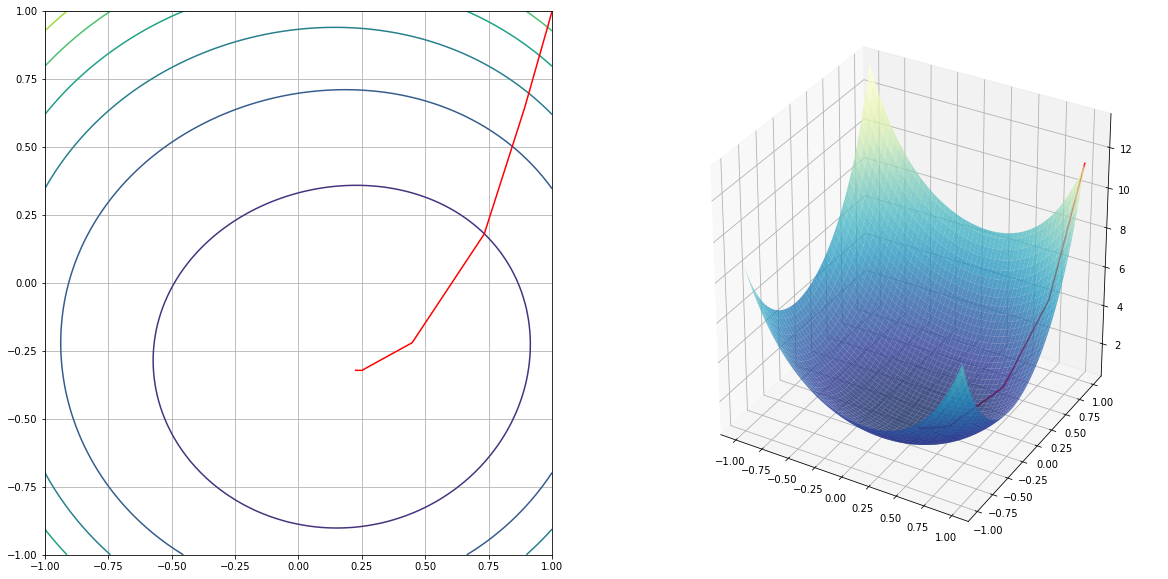

Минимум f(0.22550214592733267,-0.3211741477823603) = 0.5558020550009695


In [95]:
if __name__ == '__main__':
    f = lambda x: x[0]**2 + 2*x[1]**2 + np.exp(x[0]**2 + x[1]**2) - x[0] + 2*x[1]
    x = np.array([1, 1])
    start = time.perf_counter()
    X = newton_method(f, x, alpha=1.0)
    print('Время работы метода', time.perf_counter() - start, 'сек')
    graphic_for_3D(f, X, plane_boundaries=np.array([[-1, -1], [1, 1]]))
    print('Минимум f({},{}) = {}'.format(*X[-1], f(X[-1])))

Сверим с аналитическим решением градиента и матрицы Гесса для функции $f(x) = x_1^2 + 2x_2^2 + e^{x_1^2 + x_2^2} -x_1 + 2x_2$:

$\frac{\partial f}{\partial x_1} = 2x_1 + 2x_1e^{x_1^2 + x_2^2} - 1$

$\frac{\partial f}{\partial x_2} = 4x_2 + 2x_2e^{x_1^2 + x_2^2} + 2$

$\frac{\partial^2 f}{\partial x_1^2} = 2 + 2e^{x_1^2 + x_2^2} + 4x_1^2e^{x_1^2 + x_2^2}$

$\frac{\partial^2 f}{\partial x_1 x_2} = \frac{\partial^2 f}{\partial x_2 x_1} = 4x_1x_2e^{x_1^2 + x_2^2}$

$\frac{\partial^2 f}{\partial x_2^2} = 4 + 2e^{x_1^2 + x_2^2} + 4x_2^2e^{x_1^2 + x_2^2}$

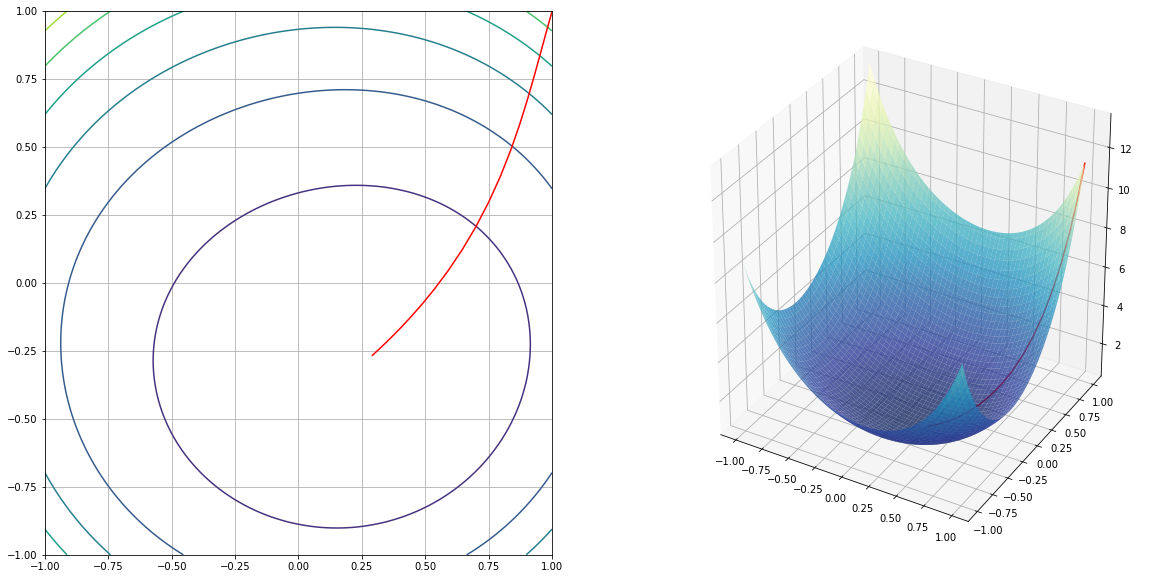

Минимум f(0.2915049862249648,-0.2660346890773706) = 0.5714832847891158
[[ 1.          1.        ]
 [ 0.9782569   0.9273192 ]
 [ 0.95550602  0.84949123]
 [ 0.93101628  0.76640296]
 [ 0.90386797  0.67825989]
 [ 0.87302122  0.58573373]
 [ 0.83747668  0.49009447]
 [ 0.79653704  0.39326552]
 [ 0.75012284  0.2977304 ]
 [ 0.69902397  0.20625195]
 [ 0.64493323  0.12144553]
 [ 0.59017461  0.0453377 ]
 [ 0.53720051 -0.0209266 ]
 [ 0.48807397 -0.07713158]
 [ 0.44414894 -0.12381704]
 [ 0.40602027 -0.16199653]
 [ 0.37366931 -0.19288472]
 [ 0.34668053 -0.21770017]
 [ 0.32443783 -0.23755325]
 [ 0.3062642  -0.25339979]
 [ 0.29150499 -0.26603469]]


In [23]:
def grad_analytically(f, x, eps=0.01):
    e = np.exp(x[0]**2 + x[1]**2)
    return np.array([2*x[0] + 2*x[0]*e - 1, 4*x[1] + 2*x[1]*e + 2])

def hess_analytically(f, x, eps=0.01): 
    e = np.exp(x[0]**2 + x[1]**2)
    return np.array([[2 + 2*e + 4*x[0]**2*e, 4*x[0]*x[1]*e], 
                     [4*x[0]*x[1]*e, 4 + 2*e + 4*x[1]**2*e]])
    
if __name__ == '__main__':
    f = lambda x: x[0]**2 + 2*x[1]**2 + np.exp(x[0]**2 + x[1]**2) - x[0] + 2*x[1]
    x = np.array([1, 1])
    start = time.perf_counter()
    X = newton_method(f, x, grad=grad_analytically, hess=hess_analytically, alpha=0.2)
    print('Время работы метода', time.perf_counter() - start, 'сек')
    graphic_for_3D(f, X, plane_boundaries=np.array([[-1, -1], [1, 1]]))
    print('Минимум f({},{}) = {}'.format(*X[-1], f(X[-1])))

Можно улучшить метод Ньютона, добавив возможность адаптивно подбирать шаг *alpha*. Для этого напишем класс, реализующий методы подбора шага (константный, условие Армихо, условие Вульфа).

In [84]:
class LineSearchTool(object):
    """
    Line search tool for adaptively tuning the step size of the algorithm.

    method : String containing 'Wolfe', 'Armijo' or 'Constant'
        Method of tuning step-size.
        Must be be one of the following strings:
            - 'Wolfe' -- enforce strong Wolfe conditions;
            - 'Armijo" -- adaptive Armijo rule;
            - 'Constant' -- constant step size.
    kwargs :
        Additional parameters of line_search method:

        If method == 'Wolfe':
            c1, c2 : Constants for strong Wolfe conditions
            alpha_0 : Starting point for the backtracking procedure
                to be used in Armijo method in case of failure of Wolfe method.
        If method == 'Armijo':
            c1 : Constant for Armijo rule
            alpha_0 : Starting point for the backtracking procedure.
        If method == 'Constant':
            c : The step size which is returned on every step.
    """
    def __init__(self, method='Wolfe', **kwargs):
        self._method = method
        if self._method == 'Wolfe':
            self.c1 = kwargs.get('c1', 1e-4)
            self.c2 = kwargs.get('c2', 0.9)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Armijo':
            self.c1 = kwargs.get('c1', 1e-4)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Constant':
            self.c = kwargs.get('c', 1.0)
        else:
            raise ValueError('Unknown method {}'.format(method))

    @classmethod
    def from_dict(cls, options):
        if type(options) != dict:
            raise TypeError('LineSearchTool initializer must be of type dict')
        return cls(**options)

    def to_dict(self):
        return self.__dict__

    def line_search(self, f, x_k, d_k, previous_alpha=None):
        """
        Finds the step size alpha for a given starting point x_k
        and for a given search direction d_k that satisfies necessary
        conditions for phi(alpha) = oracle.func(x_k + alpha * d_k).

        Parameters
        ----------
        oracle : BaseSmoothOracle-descendant object
            Oracle with .func_directional() and .grad_directional() methods implemented for computing
            function values and its directional derivatives.
        x_k : np.array
            Starting point
        d_k : np.array
            Search direction
        previous_alpha : float or None
            Starting point to use instead of self.alpha_0 to keep the progress from
             previous steps. If None, self.alpha_0, is used as a starting point.

        Returns
        -------
        alpha : float or None if failure
            Chosen step size
        """
        phi = lambda alpha: f(x_k + alpha * d_k)
        derphi = lambda alpha: grad(f, x_k + alpha * d_k).dot(d_k)
        if self._method == "Wolfe":
            result_alpha = scipy.optimize.linesearch.scalar_search_wolfe2(phi, derphi, c1=self.c1, c2=self.c2)[0]
            if result_alpha == None:
                self._method = "Armijo"
                print('Переключение на условие Арминхо')
                return self.line_search(f, x_k, d_k, previous_alpha)
        elif self._method == "Armijo":
            if previous_alpha is None:
                previous_alpha = self.alpha_0
            alpha = previous_alpha
            while phi(alpha) > phi(0) + self.c1 * alpha * derphi(0):
                alpha = alpha / 2
            result_alpha = alpha
        else:
            result_alpha = self.c
        return result_alpha
    
def get_line_search_tool(line_search_options=None):
    if line_search_options:
        if type(line_search_options) is LineSearchTool:
            return line_search_options
        else:
            return LineSearchTool.from_dict(line_search_options)
    else:
        return LineSearchTool()

In [85]:
def newton_method(f, x, line_search_options=None, grad=grad, hess=hess, eps=0.01, prec=0.001):
    line_search_tool = get_line_search_tool(line_search_options)
    x = x.astype(float)
    X = [x]
    # Аналог цикла do while
    while True:
        direct_k = grad(f, X[-1], eps).reshape((1, len(X[-1])))
        direct_k = direct_k @ np.linalg.inv(hess(f, X[-1], eps))
        direct_k = direct_k.flatten()
        alpha_k = line_search_tool.line_search(f=f, x_k=X[-1], d_k=direct_k)
        X.append(X[-1] - alpha_k * direct_k)
        if np.linalg.norm(X[-1] - X[-2]) < prec:
            break
    return np.array(X)

Переключение на условие Арминхо
Время работы метода 0.019775600001594285 сек


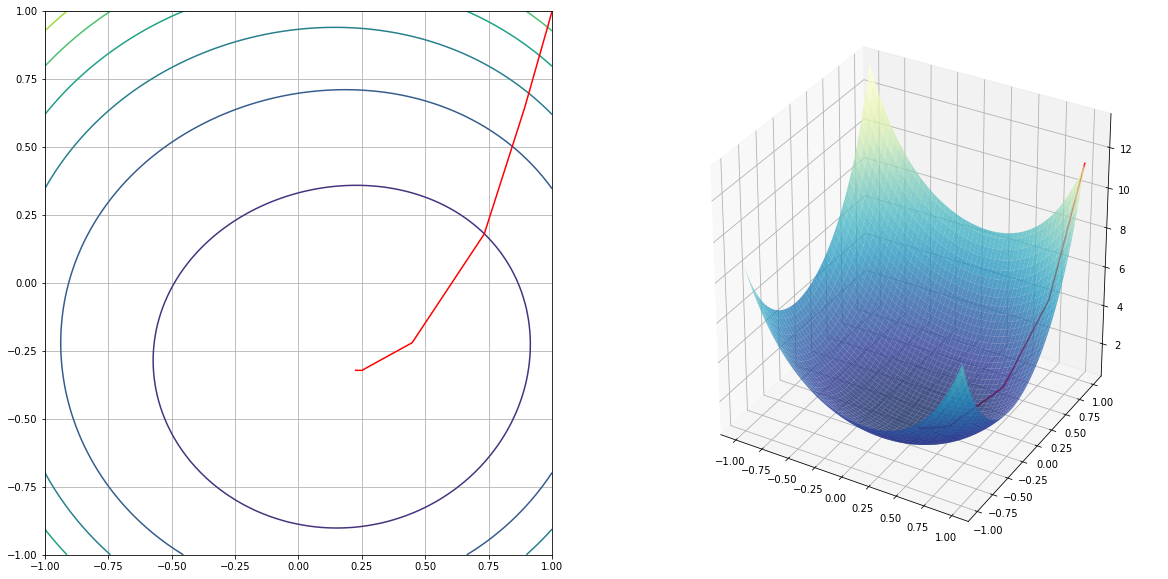

Минимум f(0.22550214592733267,-0.3211741477823603) = 0.5558020550009695


In [88]:
if __name__ == '__main__':
#     method = {'method': 'Constant', 'c': 0.2}
#     method = {'method': 'Armijo', 'alpha_0': 1.0, 'c1': 10.0} 
    method = {'method': 'Wolfe', 'c1': 10, 'c2': 0.9, 'alpha_0': 1.0}
    f = lambda x: x[0]**2 + 2*x[1]**2 + np.exp(x[0]**2 + x[1]**2) - x[0] + 2*x[1]
    
    x = np.array([1, 1])
    start = time.perf_counter()
    X = newton_method(f, x, line_search_options=method)
    print('Время работы метода', time.perf_counter() - start, 'сек')
    graphic_for_3D(f, X, plane_boundaries=np.array([[-1, -1], [1, 1]]))
    print('Минимум f({},{}) = {}'.format(*X[-1], f(X[-1])))

## Задача 3. Условная оптимизация. Метод штрафных/барьерных функций.

**Задача 17.308:** $f(x) = 2x_1 + x_2 \rightarrow min$, $(x_1 - 4)^2 + (x_2 - 2)^2 \le 1$.

In [ ]:
def f(x1, x2):
    return 2*x1 + x2

def limits(x1, x2):
    return (x1 - 4)**2 + (x2 - 2)**2

def method(f, limits):
    pass

## Интересные решения

Несмотря на то, что функция метода Ньютона неверено расписана ($x_{k+1} = x_k - \alpha \frac{\nabla f(x_k)}{\Delta f(x_k)}$ с поэлементным деленем векторов), она давала верный ответ для моей функции и для функции $f(x) = x_1^2 + x_2^2$. Такой алгоритм получился вследствии неверных обозначений в некоторых источниках и моей невнимательности.

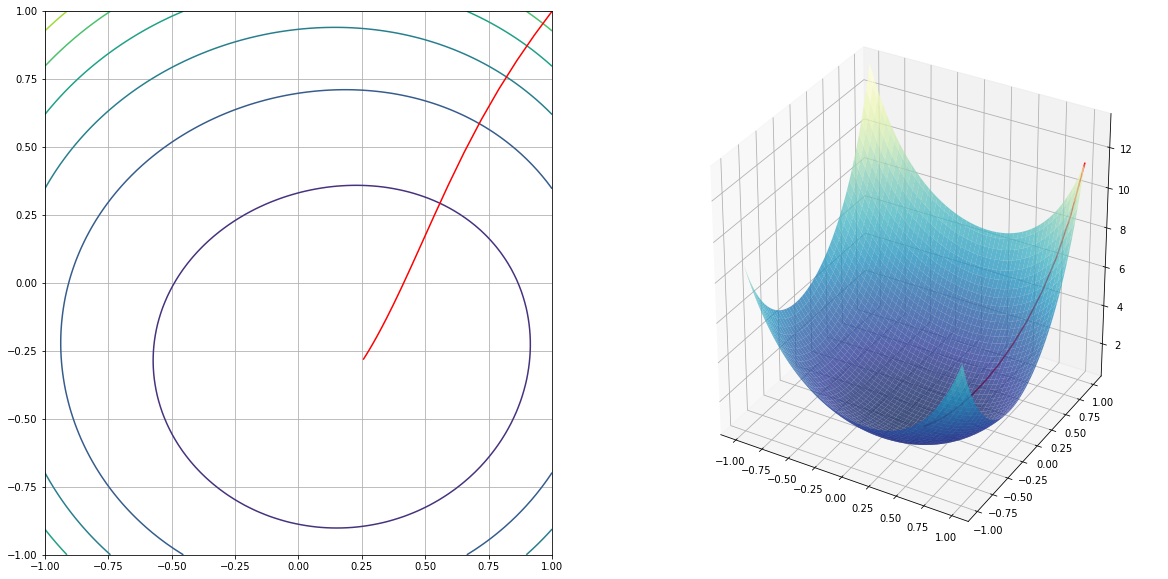

Минимум f(0.25669245100201316,-0.2797069972264058) = 0.5612873872598034


In [30]:
def laplas_operator(f, x, eps=0.01):
    n = len(x)
    x_res = np.zeros(n)
    for i in range(n):
        x_res[i] = (diff(f, x, i, eps) - diff(f, x, i, -eps)) / eps
    return x_res

def nabla_operator(f, x, eps=0.01):
    n = len(x)
    x_res = np.zeros(n)
    for i in range(n):
        x_res[i] = diff(f, x, i, eps)
    return x_res

def mistaken_newton_method(f, x, eps=0.01, steps=10, alpha=0.1):
    X = [x]
    for _ in range(steps):
        direct = nabla_operator(f, X[-1], eps) / laplas_operator(f, X[-1], eps)
        X.append(X[-1] - alpha * direct)
    return np.array(X)
    
if __name__ == '__main__':
    f = lambda x: x[0]**2 + 2*x[1]**2 + np.exp(x[0]**2 + x[1]**2) - x[0] + 2*x[1]
    x = np.array([1, 1])
    X = mistaken_newton_method(f, x, steps=20, alpha=0.2)
    graphic_for_3D(f, X, plane_boundaries=np.array([[-1, -1], [1, 1]]))
    print('Минимум f({},{}) = {}'.format(*X[-1], f(X[-1])))